<a href="https://colab.research.google.com/github/hfernandescfc/Bitcasting/blob/main/Block_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  from google.colab import drive
drive.mount('/content/drive')


!ls /content/drive/MyDrive/Dissertação/Blockchain_data


Mounted at /content/drive
ada.csv  avaxc.csv  btc.csv  eth.csv  ltc.csv  matic_eth.csv  xrp.csv


In [2]:
# prompt: create pandas dataframes from each csv file on /content/drive/MyDrive/Dissertação/Blockchain_data
# the header should be the second row
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

# Path to the directory containing the CSV files
csv_dir = '/content/drive/MyDrive/Dissertação/Blockchain_data'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Create a dictionary to store the dataframes
dataframes = {}

# Loop through each CSV file and create a dataframe
for file in csv_files:
    # Get the file name without the extension
    name = os.path.splitext(file)[0]

    # Read the CSV file into a dataframe
    df = pd.read_csv(os.path.join(csv_dir, file))

    # Store the dataframe in the dictionary using the file name as the key
    dataframes[name] = df

# Now you can access each dataframe using the file name
# For example: dataframes['ada'], dataframes['avax'], etc.

# Print the names of the created dataframes
print("Created dataframes:")
for name in dataframes.keys():
    print(f"- {name}")

# Optional: If you want to create separate variables for each dataframe
for name, df in dataframes.items():
    globals()[name] = df

# Now you can access the dataframes directly by their names
# For example: ada, avax, eth, matic_eth, sol

<ipython-input-2-52b6bd53caca>:24: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(csv_dir, file))


Created dataframes:
- ada
- matic_eth
- eth
- btc
- ltc
- xrp
- avaxc


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import os
from collections import defaultdict

# Path to the directory containing the CSV files
csv_dir = '/content/drive/MyDrive/Dissertação/Blockchain_data'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Dictionary to store feature importance counts
feature_importance_counts = defaultdict(int)

# Dictionary to store feature importance lists for each model
model_feature_importance = {}

# Function to process dataframe and run XGBoost
def process_and_run_xgb(df, name):
    # Create index with the 'time' column
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Step 1: Drop rows with null values
    df = df.iloc[:,:-1].dropna()

    # Step 2: Create Close_t+1 feature
    df['Close_t+1'] = df['PriceUSD'].shift(-1)

    # Step 3: Create change feature
    df['Change'] = df['Close_t+1'].diff()

    # Step 4: Create direction feature
    df['Direction'] = (df['Change'] > 0).astype(int)

    # Step 5: Separate features and target
    X = df.drop(['Direction', 'Change', 'Close_t+1'], axis=1)
    y = df['Direction']

    # Step 6: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 7: Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Step 8: Run XGBoost classifier
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Lists to store performance metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # List to store feature importance for all folds
    model_importances = []

    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

        # Get feature importance
        feature_importance = model.feature_importances_
        feature_indices = np.argsort(feature_importance)[::-1]

        # Create a dictionary of feature names and their importance scores
        fold_importance = {X.columns[i]: feature_importance[i] for i in feature_indices}
        model_importances.append(fold_importance)

        top_features = [X.columns[i] for i in feature_indices[:10]]
        for feature in top_features:
            feature_importance_counts[feature] += 1

    # Calculate average feature importance across folds
    avg_importance = defaultdict(float)
    for fold_imp in model_importances:
        for feature, importance in fold_imp.items():
            avg_importance[feature] += importance

    avg_importance = {k: v/len(model_importances) for k, v in avg_importance.items()}

    # Store the average feature importance for this model
    model_feature_importance[name] = dict(sorted(avg_importance.items(),
                                               key=lambda x: x[1],
                                               reverse=True))

    # Print results
    print(f"\nResults for {name}:")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average Precision: {np.mean(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f}")
    print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

    # Print top 10 features for this model
    print("\nTop 10 Features:")
    for feature, importance in list(model_feature_importance[name].items())[:10]:
        print(f"{feature}: {importance:.4f}")

# Process each CSV file
for file in csv_files:
    name = os.path.splitext(file)[0]
    df = pd.read_csv(os.path.join(csv_dir, file))
    process_and_run_xgb(df, name)

# Save feature importance for each model to CSV files
for model_name, importance_dict in model_feature_importance.items():
    importance_df = pd.DataFrame.from_dict(importance_dict,
                                         orient='index',
                                         columns=['Importance'])
    importance_df.to_csv(f'{model_name}_feature_importance.csv')

# Print overall feature importance counts
print("\nOverall Feature Importance Counts:")
for feature, count in sorted(feature_importance_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {count}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for ada:
Average Accuracy: 0.4804
Average Precision: 0.5270
Average Recall: 0.5474
Average F1-Score: 0.4318

Top 10 Features:
AdrBalNtv100KCnt: 0.0295
AdrBalUSD10MCnt: 0.0254
SplyAdrBalUSD10K: 0.0191
AdrBalNtv1MCnt: 0.0185
VtyDayRet180d: 0.0182
ROI1yr: 0.0180
NVTAdj90: 0.0178
SplyAct30d: 0.0173
FeeMedUSD: 0.0168
SplyAdrBalUSD1M: 0.0168


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for matic_eth:
Average Accuracy: 0.4939
Average Precision: 0.6060
Average Recall: 0.4741
Average F1-Score: 0.3802

Top 10 Features:
SplyAdrBalNtv0.001: 0.0364
SplyAdrBal1in1M: 0.0213
SplyAdrBal1in10M: 0.0205
AdrBal1in10KCnt: 0.0200
SplyAdrBalUSD100K: 0.0198
CapRealUSD: 0.0192
AdrBal1in100MCnt: 0.0179
AdrBal1in1MCnt: 0.0178
SplyAdrBal1in100M: 0.0171
CapMrktFFUSD: 0.0171


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for eth:
Average Accuracy: 0.4667
Average Precision: 0.4703
Average Recall: 0.8785
Average F1-Score: 0.6011

Top 10 Features:
VtyDayRet30d: 0.0376
GasLmtBlk: 0.0374
BlkCnt: 0.0324
SplyAdrBalUSD10K: 0.0304
AdrBalUSD1Cnt: 0.0297
SplyAct7d: 0.0263
AdrBal1in100MCnt: 0.0253
VtyDayRet180d: 0.0245
ROI30d: 0.0234
SplyAct30d: 0.0213


<ipython-input-3-a15eda360787>:115: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(csv_dir, file))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:44:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

 


Results for btc:
Average Accuracy: 0.5224
Average Precision: 0.5985
Average Recall: 0.2949
Average F1-Score: 0.3504

Top 10 Features:
AdrBalUSD10Cnt: 0.0262
AdrBalUSD100KCnt: 0.0214
AdrBalNtv10KCnt: 0.0211
SplyAdrBalNtv100: 0.0205
VtyDayRet180d: 0.0196
AdrBal1in1KCnt: 0.0171
SplyAct4yr: 0.0158
AdrBal1in1MCnt: 0.0158
HashRate30d: 0.0139
SplyAdrBalUSD10K: 0.0139


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for ltc:
Average Accuracy: 0.5364
Average Precision: 0.5574
Average Recall: 0.6740
Average F1-Score: 0.5853

Top 10 Features:
AdrBalNtv0.001Cnt: 0.0286
AdrBal1in1KCnt: 0.0243
AdrBalUSD10KCnt: 0.0232
SplyAdrBalUSD10K: 0.0216
CapMVRVCur: 0.0192
SplyAct1yr: 0.0183
PriceBTC: 0.0176
SplyAdrBalUSD1K: 0.0171
AdrBal1in10KCnt: 0.0161
AdrBalUSD1MCnt: 0.0154


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for xrp:
Average Accuracy: 0.5255
Average Precision: 0.5600
Average Recall: 0.3000
Average F1-Score: 0.3706

Top 10 Features:
CapMVRVFF: 0.0285
AdrBalUSD100KCnt: 0.0272
SplyAdrBalUSD10: 0.0261
CapMrktCurUSD: 0.0235
AdrBalUSD10KCnt: 0.0210
PriceBTC: 0.0210
SplyAdrBalUSD1M: 0.0208
ROI1yr: 0.0206
CapMVRVCur: 0.0205
ReferenceRateBTC: 0.0204


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:45:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Results for avaxc:
Average Accuracy: 0.5034
Average Precision: 0.5229
Average Recall: 0.6032
Average F1-Score: 0.5125

Top 10 Features:
SplyAct180d: 0.0220
AdrBal1in1BCnt: 0.0203
SplyAct10yr: 0.0202
AdrBalUSD10KCnt: 0.0196
AdrBal1in10MCnt: 0.0193
SplyAdrBalUSD10M: 0.0191
AdrBalUSD100Cnt: 0.0188
SplyAdrBalNtv100K: 0.0182
AdrBal1in10BCnt: 0.0167
NDF: 0.0166

Overall Feature Importance Counts:
AdrBalUSD100KCnt: 13
VtyDayRet180d: 9
AdrBalUSD10Cnt: 9
AdrBal1in100MCnt: 8
AdrBal1in1MCnt: 8
SplyAdrBalUSD1K: 8
SplyAct180d: 7
AdrBalUSD100Cnt: 7
SplyAdrBalUSD10K: 7
AdrBalUSD1Cnt: 7
SplyFF: 5
BlkCnt: 5
AdrBalNtv100KCnt: 5
AdrBalUSD1MCnt: 5
SplyAdrBalUSD10M: 5
AdrBal1in1BCnt: 5
NDF: 5
AdrBalUSD1KCnt: 5
CapMrktCurUSD: 5
SplyAdrBalNtv0.001: 5
SplyAdrBalUSD100K: 5
AdrBal1in10KCnt: 5
CapRealUSD: 5
SplyAct4yr: 5
VtyDayRet30d: 5
AdrBal1in10MCnt: 5
AdrBalUSD10KCnt: 5
AdrBalUSD10MCnt: 4
SplyAct30d: 4
AdrBalNtv10Cnt: 4
ROI1yr: 4
AdrBal1in1KCnt: 4
NVTAdjFF90: 4
SER: 4
CapMVRVFF: 4
SplyAdrBalUSD10: 4
CapMVRV

In [4]:

# Method 1: Using sorted() with lambda
top_10_keys = list(dict(sorted(model_feature_importance['btc'].items(),
                              key=lambda x: x[1],
                              reverse=True)[:20]).keys())
''' top_10_keys = ['AdrBalUSD10Cnt',
 'AdrBalUSD100KCnt',
 'AdrBalNtv10KCnt',
 'SplyAdrBalNtv100',
 'VtyDayRet180d',
 'AdrBal1in1KCnt',
 'SplyAct4yr',
 'AdrBal1in1MCnt',
 'HashRate30d',
 'SplyAdrBalUSD10K',
               'PriceUSD'] '''

" top_10_keys = ['AdrBalUSD10Cnt',\n 'AdrBalUSD100KCnt',\n 'AdrBalNtv10KCnt',\n 'SplyAdrBalNtv100',\n 'VtyDayRet180d',\n 'AdrBal1in1KCnt',\n 'SplyAct4yr',\n 'AdrBal1in1MCnt',\n 'HashRate30d',\n 'SplyAdrBalUSD10K',\n               'PriceUSD'] "

In [5]:
top_10_keys

['AdrBalUSD10Cnt',
 'AdrBalUSD100KCnt',
 'AdrBalNtv10KCnt',
 'SplyAdrBalNtv100',
 'VtyDayRet180d',
 'AdrBal1in1KCnt',
 'SplyAct4yr',
 'AdrBal1in1MCnt',
 'HashRate30d',
 'SplyAdrBalUSD10K',
 'ReferenceRate',
 'SplyAdrBalNtv1K',
 'NDF',
 'ReferenceRateEUR',
 'FlowInExNtv',
 'FeeByteMeanNtv',
 'AdrBalUSD1Cnt',
 'AdrBal1in10MCnt',
 'AdrBalUSD100Cnt',
 'SplyAct5yr']

In [6]:
btc = btc[btc['time'] >= '2017-08-17']

In [7]:
btc = btc.drop(columns = ['principal_market_usd', 'principal_market_price_usd', 'CapMrktEstUSD'])

In [8]:
missing = btc.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(btc) * 100).round(2)
missing_df = pd.DataFrame({'n_missing': missing, 'pct_missing': missing_pct})
missing_df

,n_missing,pct_missing
VtyDayRet30d,1,0.04
SplyActPct1yr,1,0.04
SplyAct3yr,1,0.04
SplyAct4yr,1,0.04
SplyAct5yr,1,0.04
...,...,...
time,0,0.00
ReferenceRateUSD,0,0.00
ReferenceRateEUR,0,0.00
ReferenceRateETH,0,0.00


In [9]:
btc.set_index('time', inplace=True)

In [10]:
btc['Close_t+1'] = btc['PriceUSD'].shift(-1)

btc['Change'] = btc['Close_t+1'].diff()

btc['Direction'] = (btc['Change'] > 0).astype(int)

btc.dropna(inplace=True)

In [11]:
btc_set = pd.concat([btc[top_10_keys], btc['Direction']], axis = 1)

In [12]:
object_columns = btc.select_dtypes(include=['object']).columns

In [13]:
btc = btc.drop(object_columns, axis = 1)

In [14]:
''' import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV  # Import faltante
from sklearn.preprocessing import StandardScaler     # Import faltante
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Verificação de dados faltantes
if btc.isnull().any().any():
    print("Aviso: Existem valores nulos no dataset")

# Prepare features and target
X = btc.drop(['Direction', 'Close_t+1', 'Change'], axis=1)
#X = btc_set.drop('Direction', axis=1)
y = btc['Direction']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize StandardScaler
scaler = StandardScaler()

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize XGBoost classifier with scale_pos_weight para dados desbalanceados
model = XGBClassifier(random_state=42, scale_pos_weight=np.sum(y == 0) / np.sum(y == 1))

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1'  # Definindo métrica de avaliação
)

# Fit RandomizedSearchCV
X_scaled = scaler.fit_transform(X)
random_search.fit(X_scaled, y)

# Get the best model
best_model = random_search.best_estimator_

# Initialize lists to store performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform time series cross-validation with the best model
for i, (train_index, test_index) in enumerate(tscv.split(X)):  # Adicionado enumerate
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f'Fold {i+1}:')
    print(f'Train size: {len(X_train)}')  # Corrigido
    print(f'Test size: {len(X_test)}')    # Corrigido
    print(f'Test indices: {test_index[0]} to {test_index[-1]}\n')

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    best_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and store performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Adicionar validação das previsões
    if len(np.unique(y_pred)) == 1:
        print(f"Aviso: Todas as previsões são da mesma classe no fold {i+1}")

# Print average metrics with std
print("\nMétricas de avaliação:")
print(f"Accuracy: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
print(f"Precision: {np.mean(precisions):.4f} (±{np.std(precisions):.4f})")
print(f"Recall: {np.mean(recalls):.4f} (±{np.std(recalls):.4f})")
print(f"F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Last Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')  # Salvando o gráfico
plt.show()

# Feature importance
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')  # Salvando o gráfico
plt.show()

# Salvar métricas e parâmetros em um arquivo
results = {
    'best_params': random_search.best_params_,
    'metrics': {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1_scores)
    }
}

with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nMelhores hiperparâmetros:", random_search.best_params_) '''

' import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV  # Import faltante\nfrom sklearn.preprocessing import StandardScaler     # Import faltante\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix\nfrom xgboost import XGBClassifier\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport json\n\n# Verificação de dados faltantes\nif btc.isnull().any().any():\n    print("Aviso: Existem valores nulos no dataset")\n\n# Prepare features and target\nX = btc.drop([\'Direction\', \'Close_t+1\', \'Change\'], axis=1)\n#X = btc_set.drop(\'Direction\', axis=1)\ny = btc[\'Direction\']\n\n# Initialize TimeSeriesSplit\ntscv = TimeSeriesSplit(n_splits=5)\n\n# Initialize StandardScaler\nscaler = StandardScaler()\n\n# Define parameter grid for RandomizedSearchCV\nparam_grid = {\n    \'n_estimators\': [100, 200, 300, 400, 500],\n    \'max_depth\': [3, 4, 5, 6, 7, 8],\n    \'learning_rate

In [15]:
horizontes = [1, 3, 7, 14, 30]

# Função para calcular a direção com base no preço de fechamento
def calcular_direcao(close, periodo):
    return (close.shift(-periodo) > close).astype(int)
    return (close.shift(-periodo))

# Criar colunas de 'Direction_t+n' para cada horizonte desejado
for horizonte in horizontes:
    coluna_direcao = f'Direction_t+{horizonte}'
    btc[coluna_direcao] = calcular_direcao(btc['PriceUSD'], horizonte)
    close_t = f'Close_t+{horizonte}'
    btc[close_t] = btc['PriceUSD'].shift(-horizonte)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



Evaluating XGBoost model:


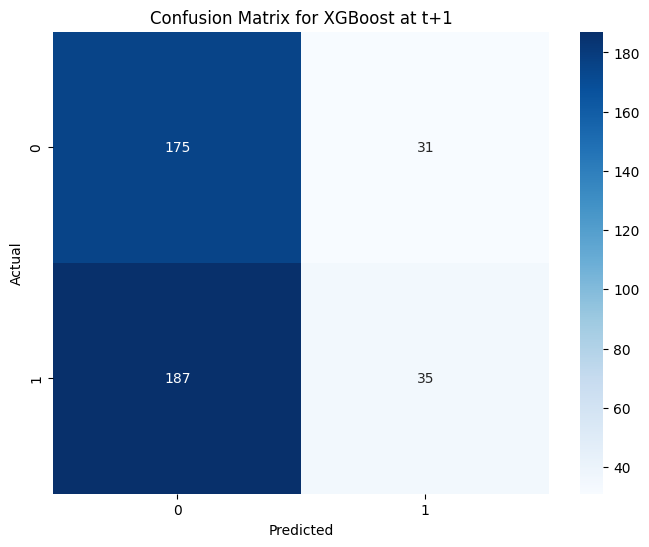

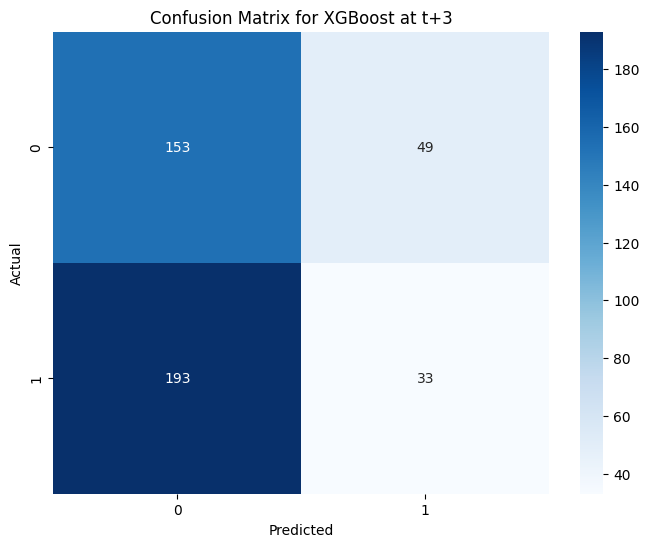

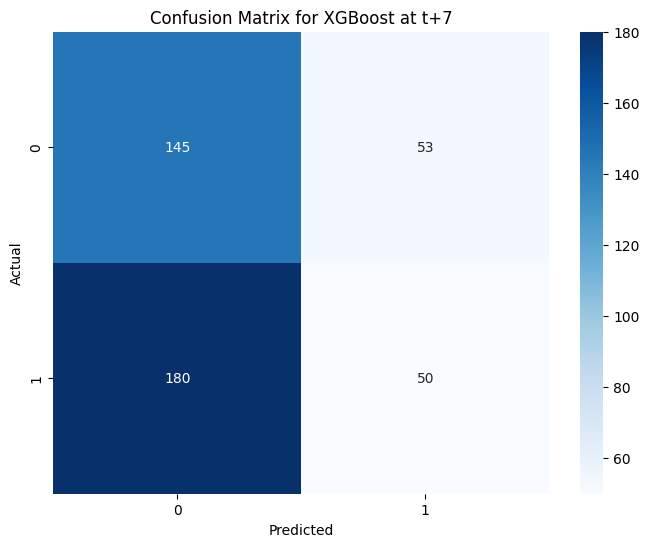

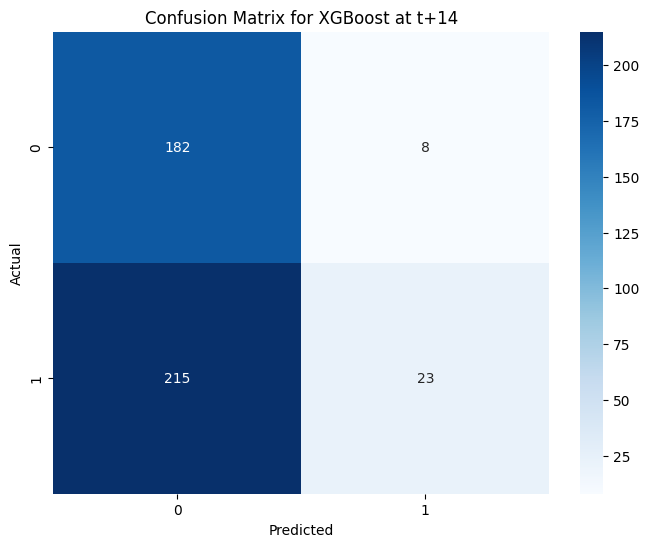

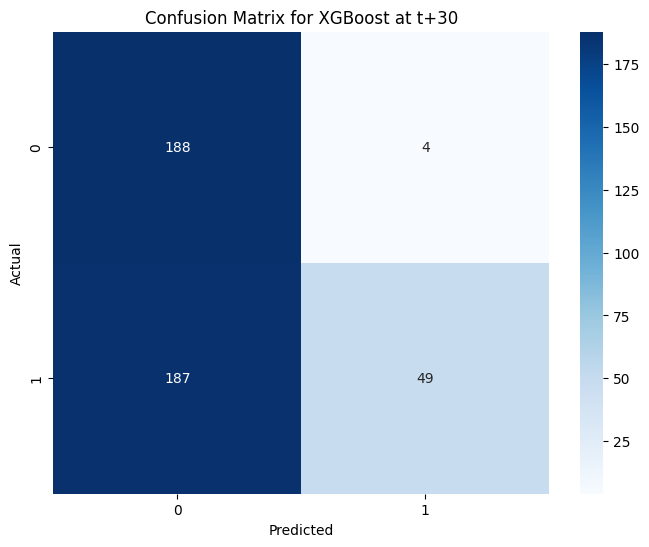


Evaluating LightGBM model:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

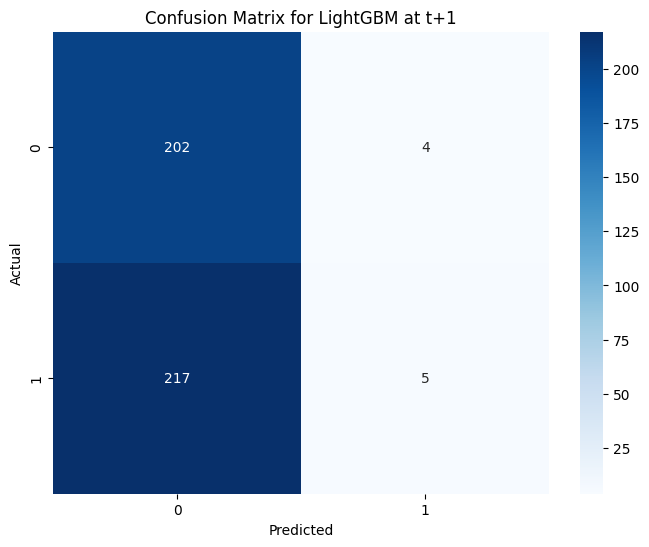

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

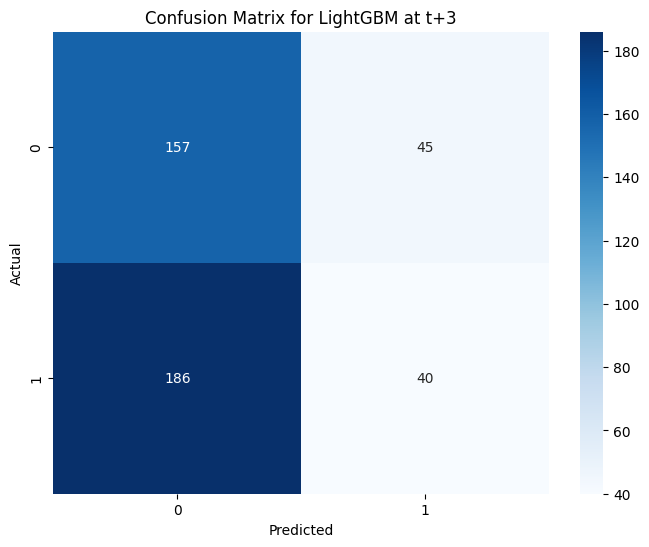

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

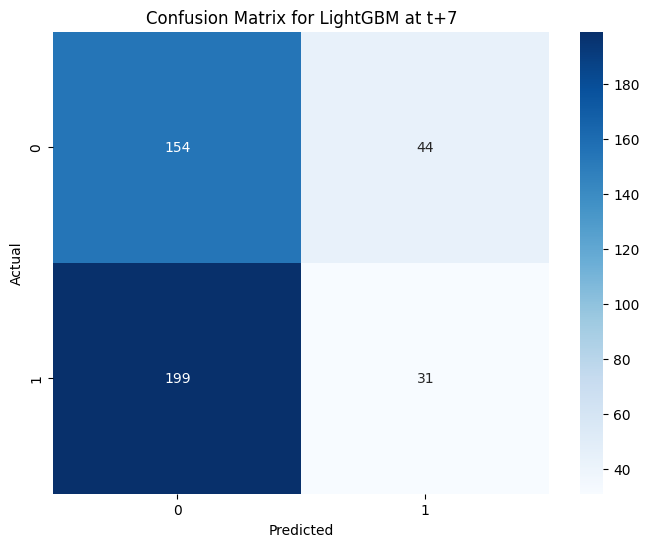

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

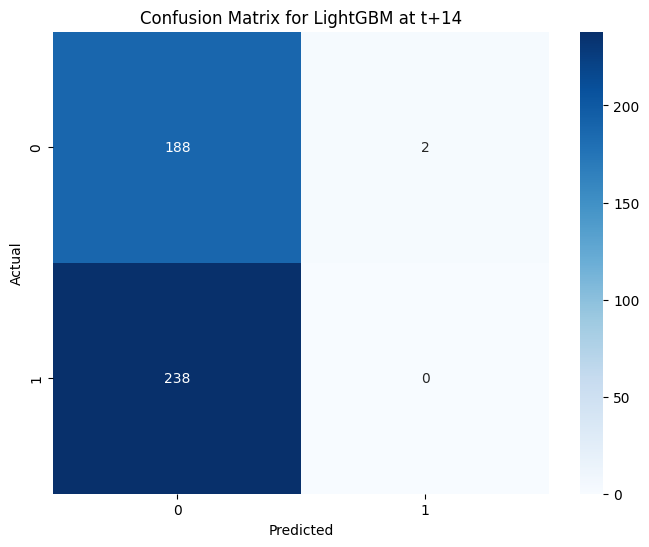

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

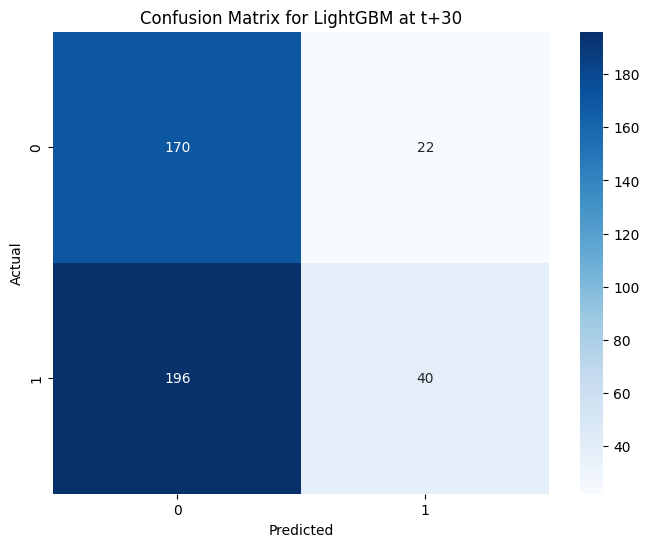


Results Summary:
      Model Horizonte  Mean Accuracy  Mean Precision  Mean Recall  \
0   XGBoost       t+1       0.491589        0.530514     0.381005   
1   XGBoost       t+3       0.487383        0.509298     0.374593   
2   XGBoost       t+7       0.478505        0.513389     0.335063   
3   XGBoost      t+14       0.490654        0.632791     0.411030   
4   XGBoost      t+30       0.579907        0.658191     0.649476   
5  LightGBM       t+1       0.489252        0.530718     0.445331   
6  LightGBM       t+3       0.489252        0.544669     0.496398   
7  LightGBM       t+7       0.473364        0.544821     0.301843   
8  LightGBM      t+14       0.466355        0.498911     0.296564   
9  LightGBM      t+30       0.569159        0.620409     0.474665   

   Mean F1 Score  
0       0.404376  
1       0.401018  
2       0.368252  
3       0.404442  
4       0.579791  
5       0.381671  
6       0.451487  
7       0.328417  
8       0.323165  
9       0.463269  

Average Metr

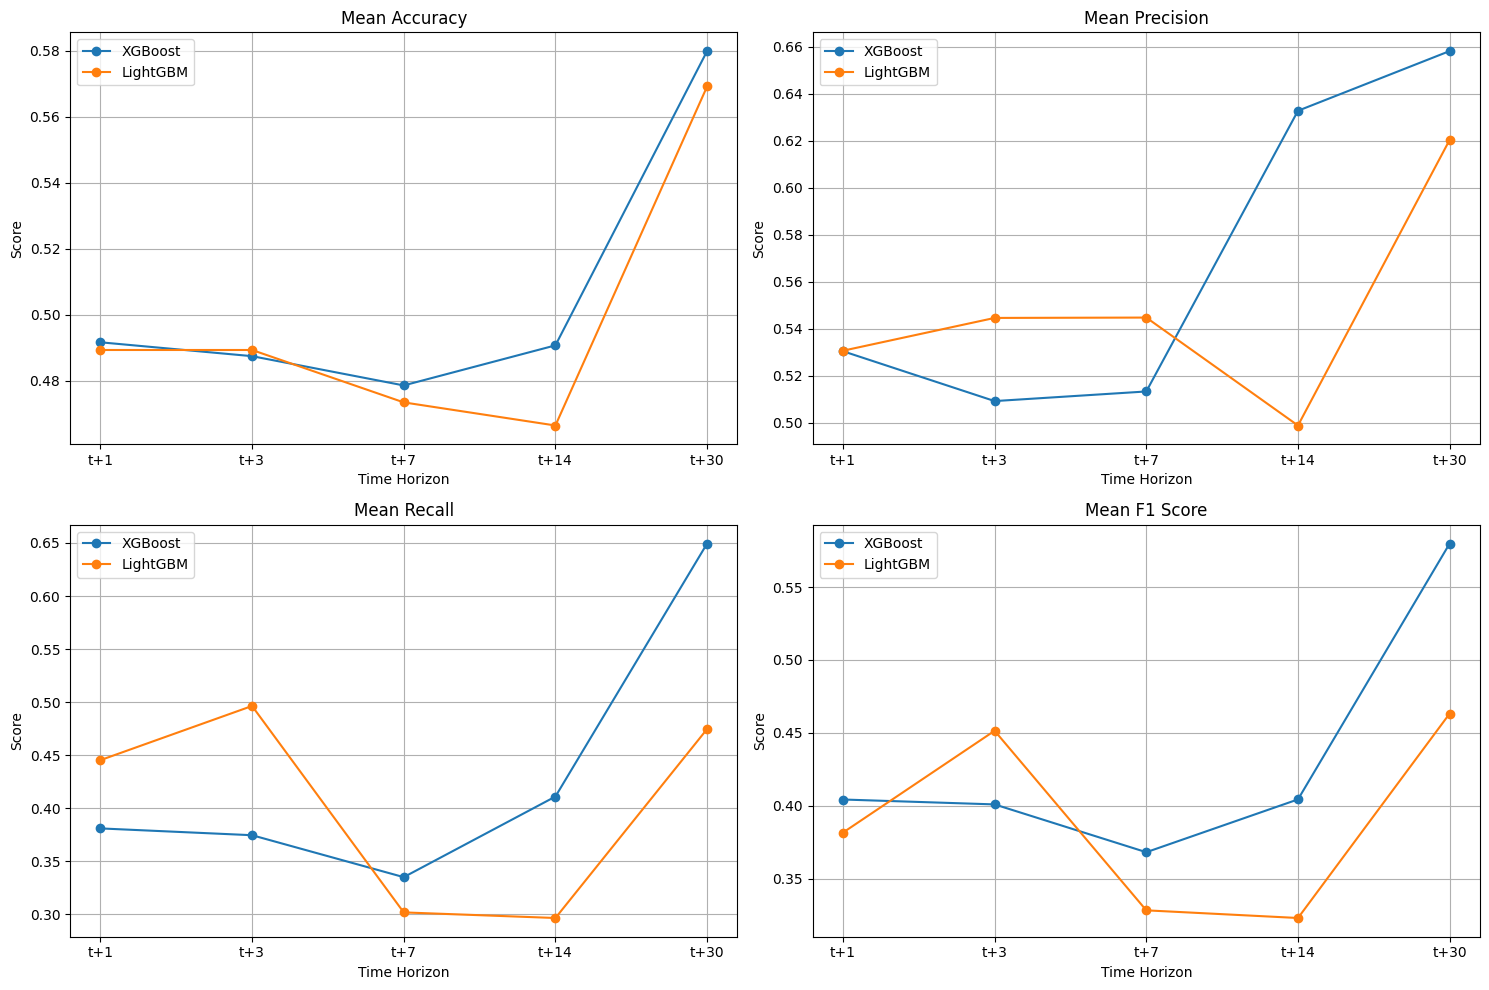

In [16]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd


models = {
    "XGBoost": XGBClassifier (random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity = 0)
}

all_results = []

for model_name, model in models.items():
    print(f"\nEvaluating {model_name} model:")

    for horizonte in horizontes:
        # Prepare features and target
        target_col = f'Direction_t+{horizonte}'

        btc_df_h = btc.dropna(subset=[target_col])

        X = btc_df_h.iloc[:,:-13]
        y = btc_df_h[target_col]

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        # Initialize StandardScaler
        scaler = StandardScaler()

        metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': []
        }

        # Cross-validation loop
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Scale the features
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Train model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['Recall'].append(recall_score(y_test, y_pred))
            metrics['F1 Score'].append(f1_score(y_test, y_pred))

        # Store average metrics
        all_results.append({
            'Model': model_name,
            'Horizonte': f't+{horizonte}',
            'Mean Accuracy': np.mean(metrics['Accuracy']),
            'Mean Precision': np.mean(metrics['Precision']),
            'Mean Recall': np.mean(metrics['Recall']),
            'Mean F1 Score': np.mean(metrics['F1 Score'])
        })

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name} at t+{horizonte}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Convert results to DataFrame and display
results_df = pd.DataFrame(all_results)

# Display results grouped by model and horizon
print("\nResults Summary:")
print(results_df)

# Calculate and display average metrics by model
print("\nAverage Metrics by Model:")
model_averages = results_df.groupby('Model')[['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score']].mean()
print(model_averages)

# Create comparison plots
metrics_to_plot = ['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    for model in models.keys():
        model_data = results_df[results_df['Model'] == model]
        plt.plot(model_data['Horizonte'], model_data[metric], marker='o', label=model)
    plt.title(metric)
    plt.xlabel('Time Horizon')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Performing feature selection for XGBoost:


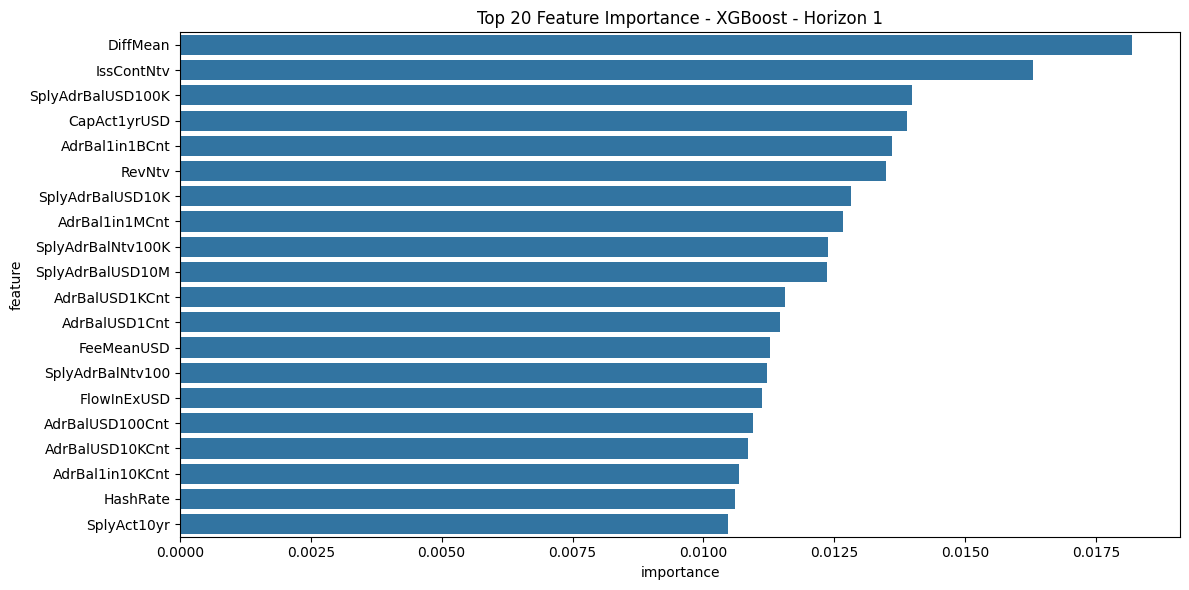

Selected 2 features for horizon 1


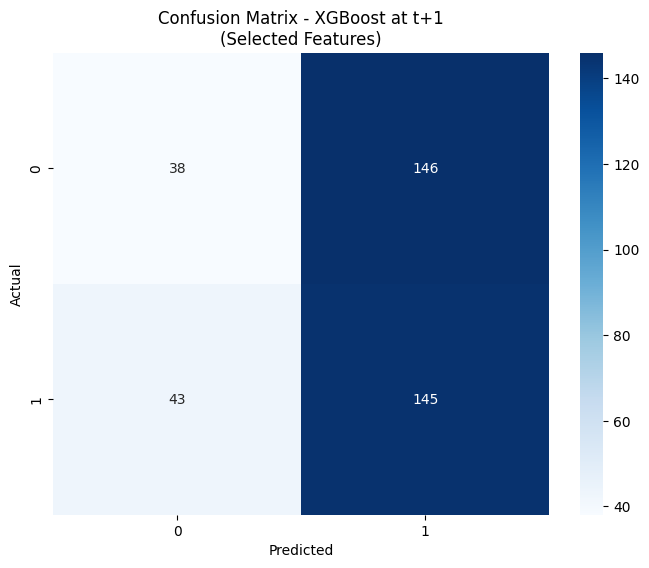

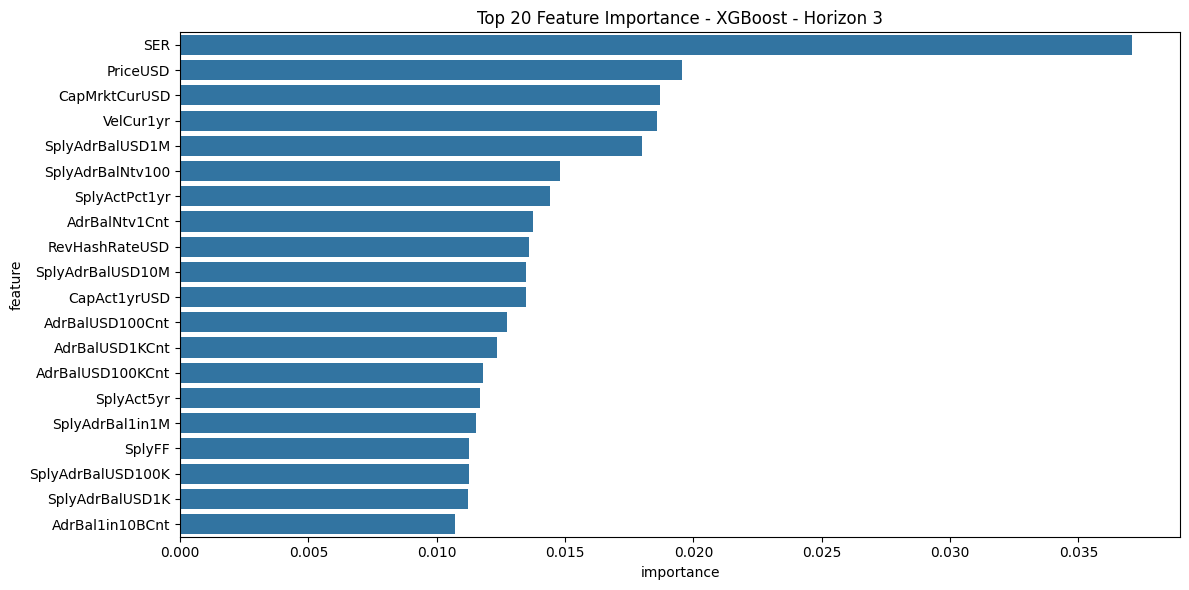

Selected 5 features for horizon 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


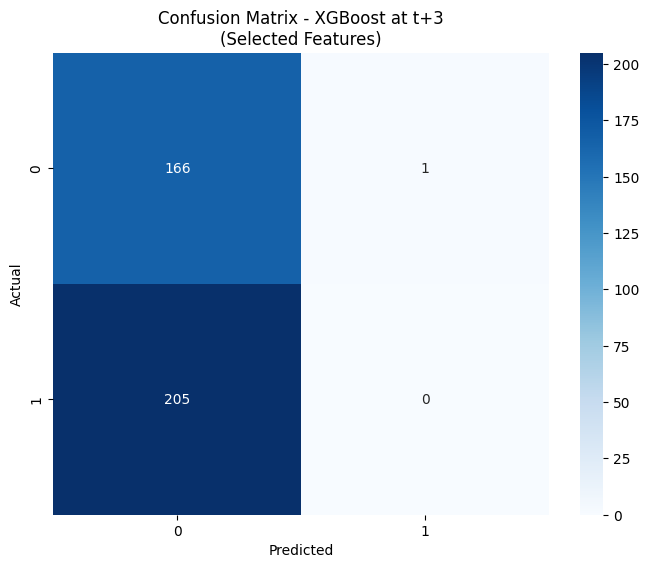

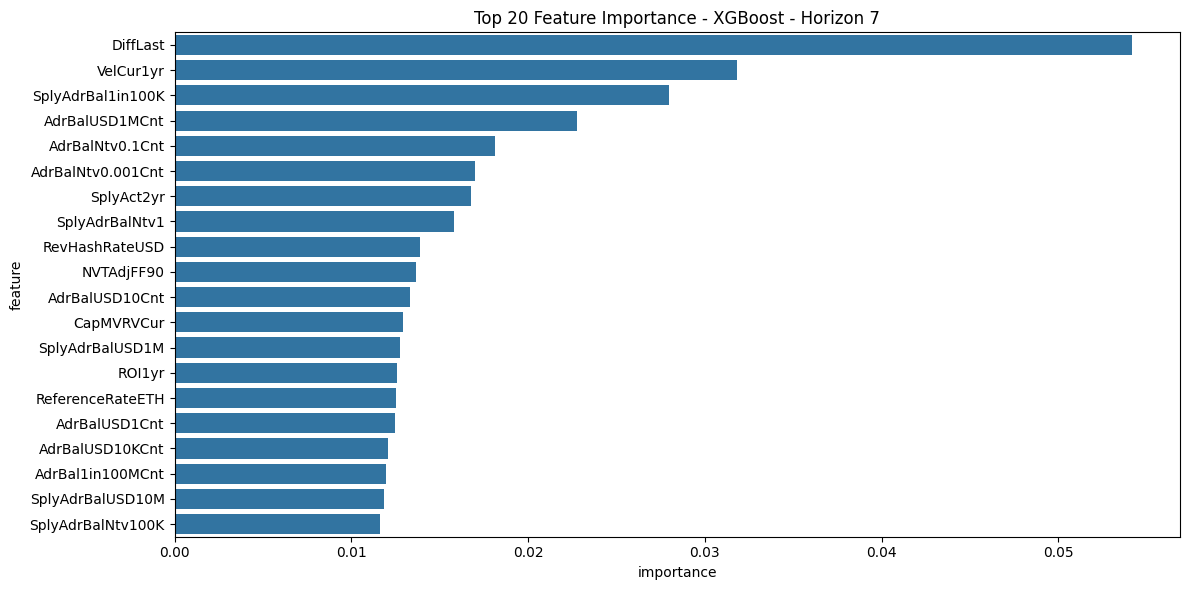

Selected 8 features for horizon 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


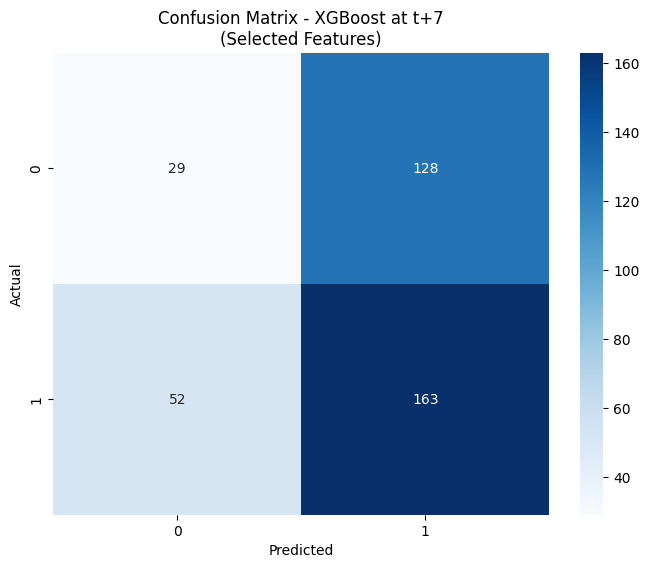

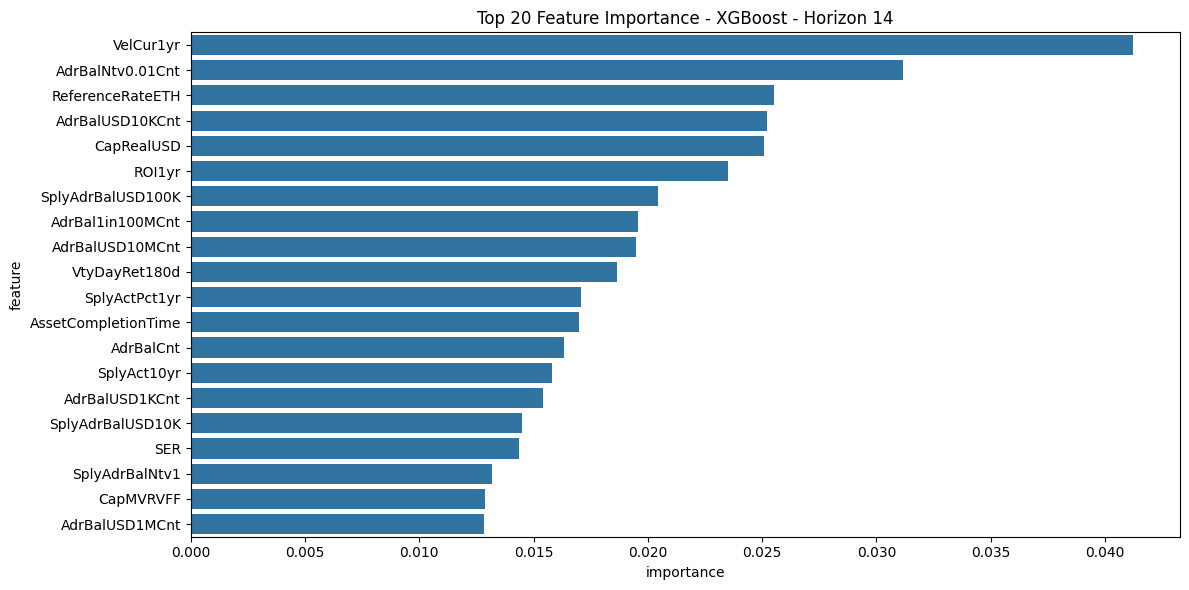

Selected 15 features for horizon 14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


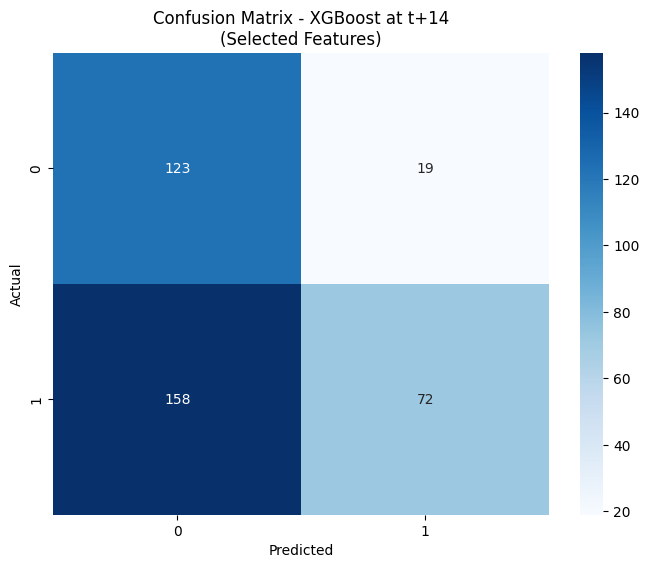

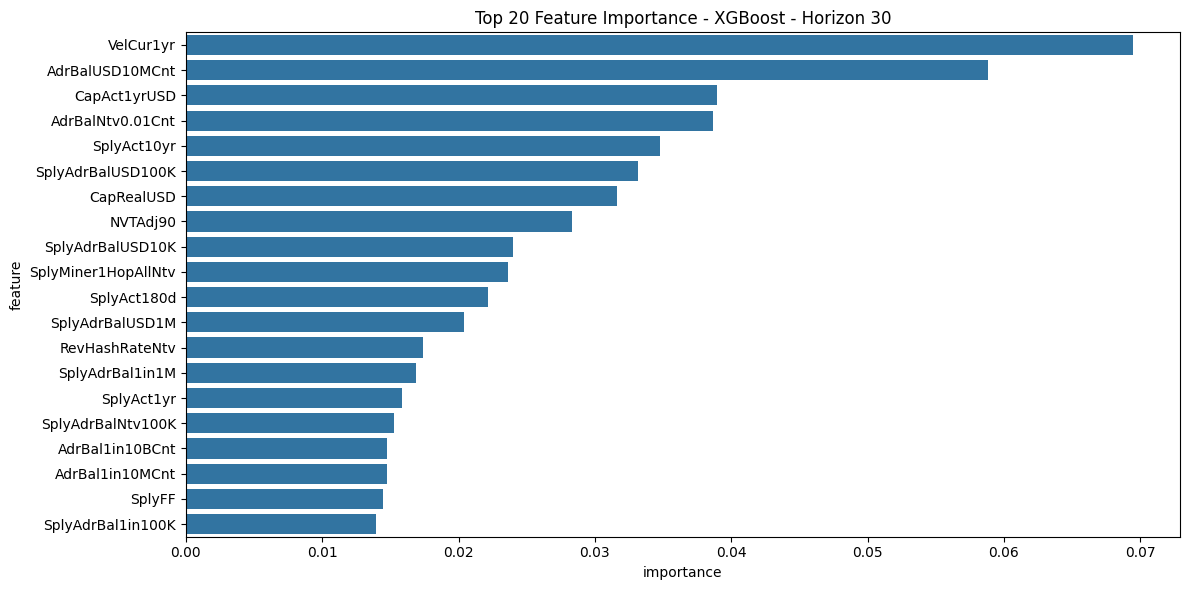

Selected 16 features for horizon 30


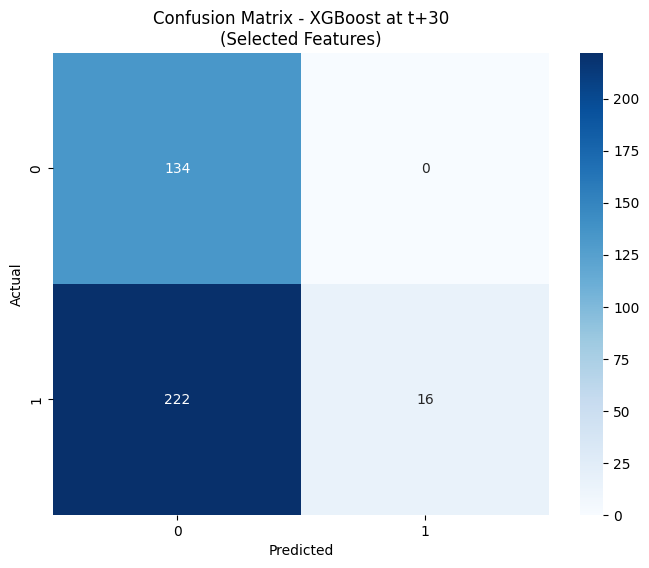


Performing feature selection for LightGBM:


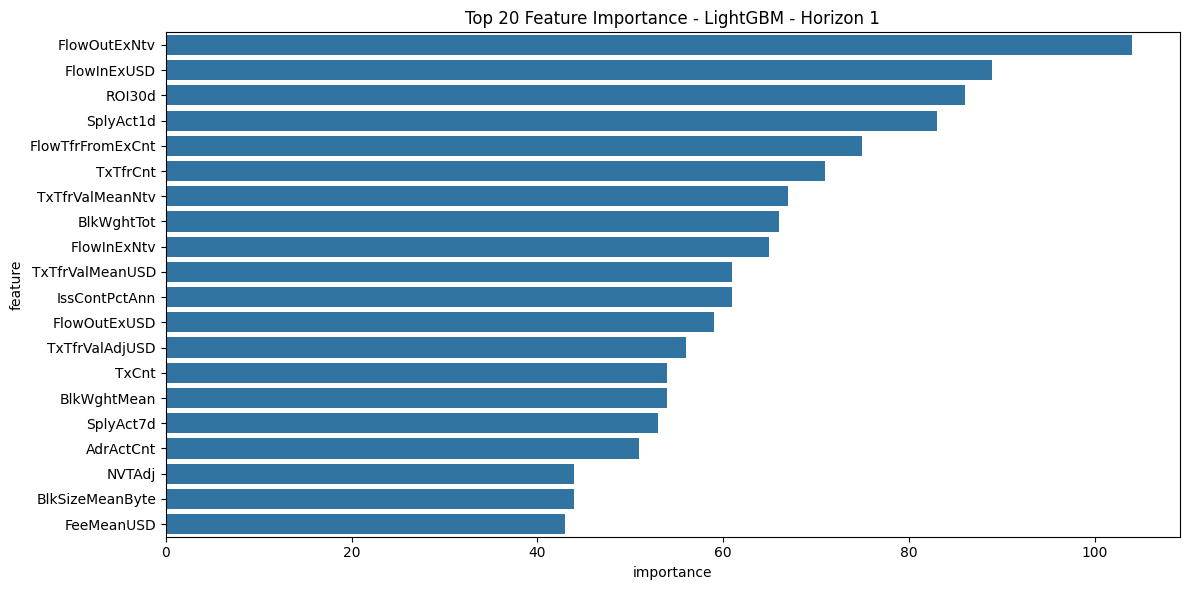

Selected 23 features for horizon 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

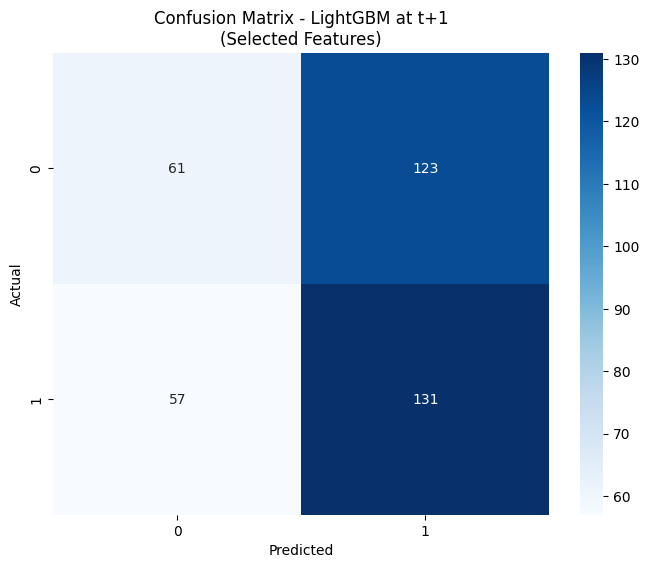

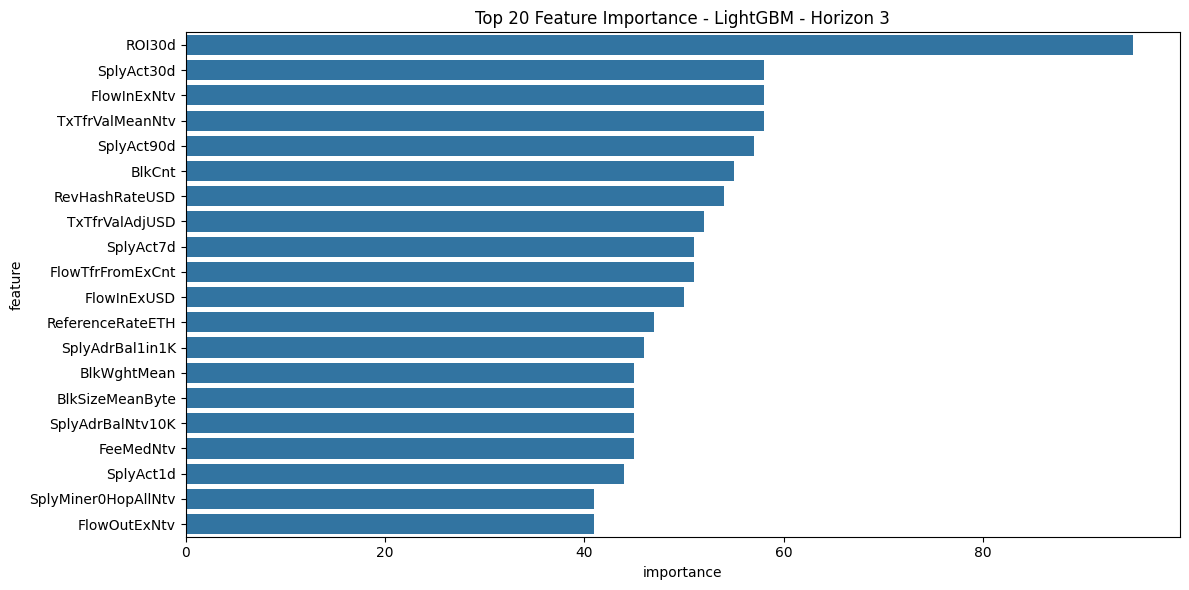

Selected 20 features for horizon 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

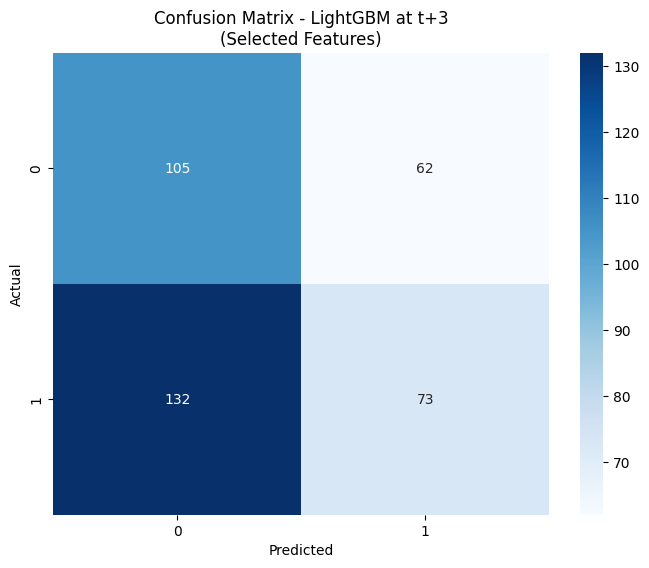

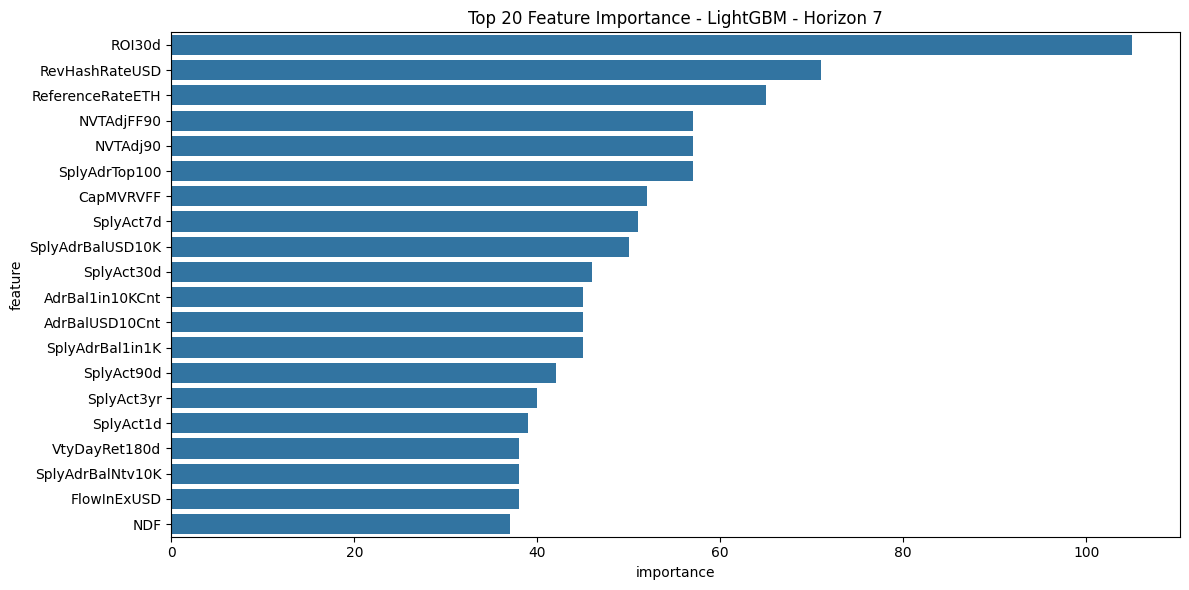

Selected 14 features for horizon 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

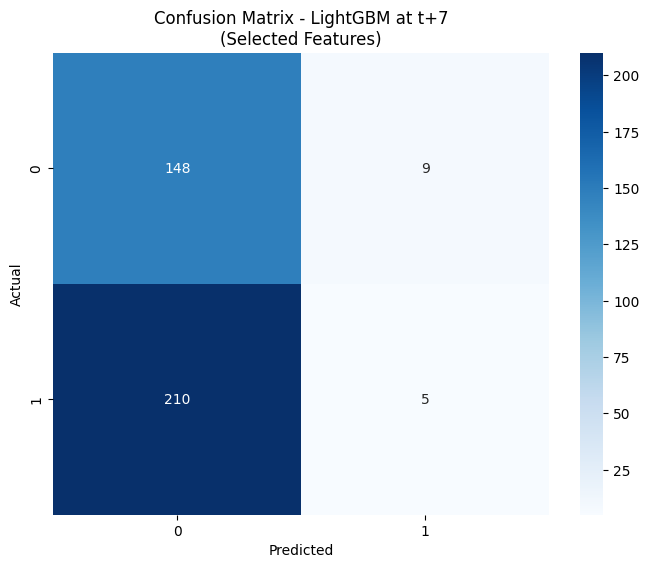

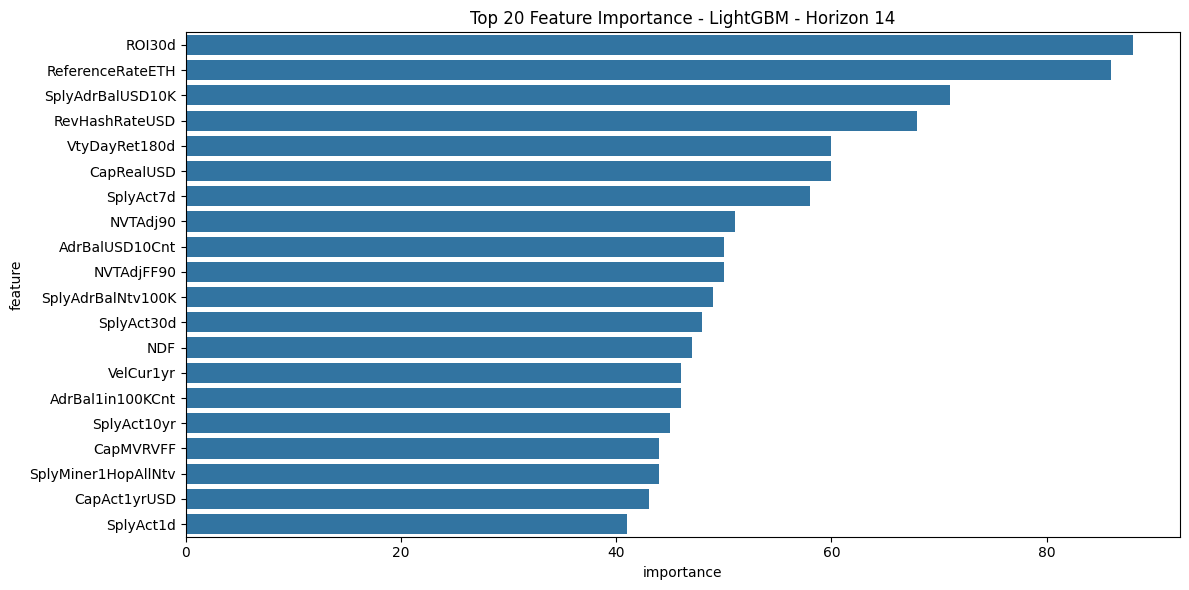

Selected 21 features for horizon 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


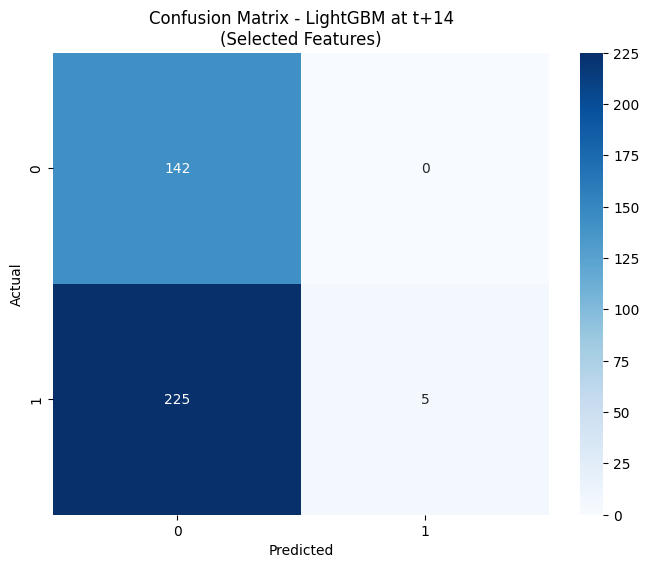

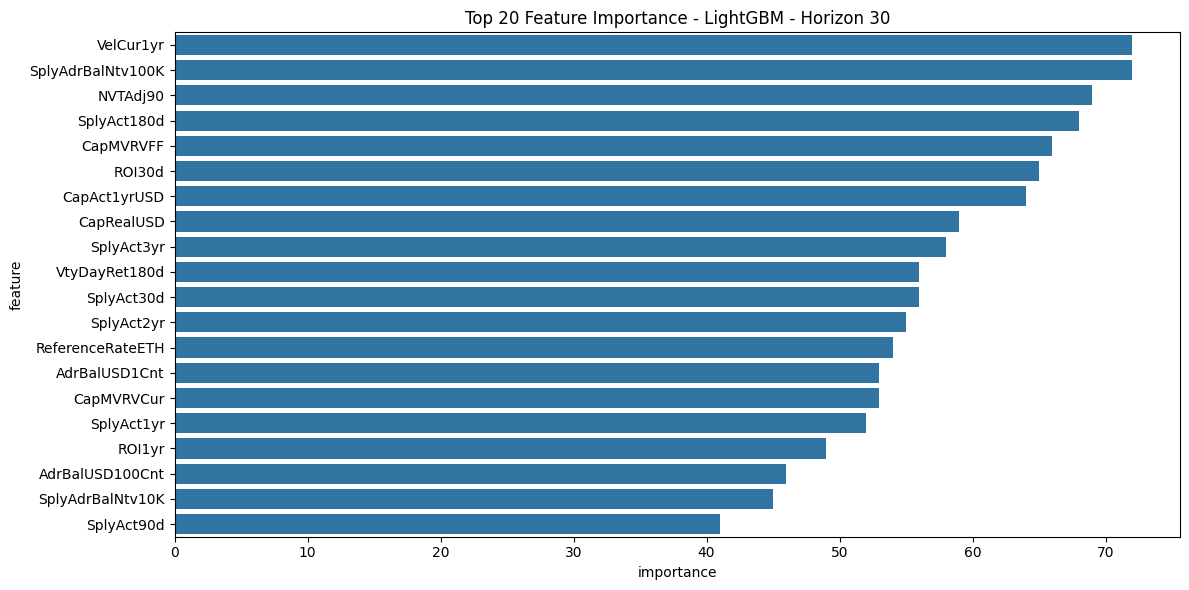

Selected 21 features for horizon 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

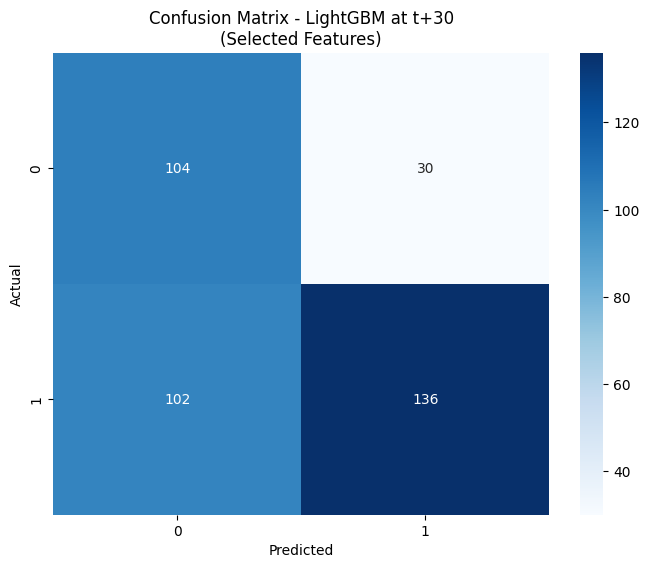


Results with Selected Features:
      Model Horizonte  N_Features  Mean Accuracy  Mean Precision  Mean Recall  \
0   XGBoost       t+1           2       0.468817        0.485244     0.521314   
1   XGBoost       t+3           5       0.483333        0.385233     0.153708   
2   XGBoost       t+7           8       0.478495        0.507051     0.536845   
3   XGBoost      t+14          15       0.475269        0.592412     0.280643   
4   XGBoost      t+30          16       0.518280        0.709354     0.514079   
5  LightGBM       t+1          23       0.500000        0.552161     0.519478   
6  LightGBM       t+3          20       0.524194        0.567754     0.485556   
7  LightGBM       t+7          14       0.453763        0.613156     0.245452   
8  LightGBM      t+14          21       0.483871        0.605951     0.294204   
9  LightGBM      t+30          21       0.576882        0.689469     0.525459   

   Mean F1 Score  
0       0.479422  
1       0.193147  
2       0.401756  

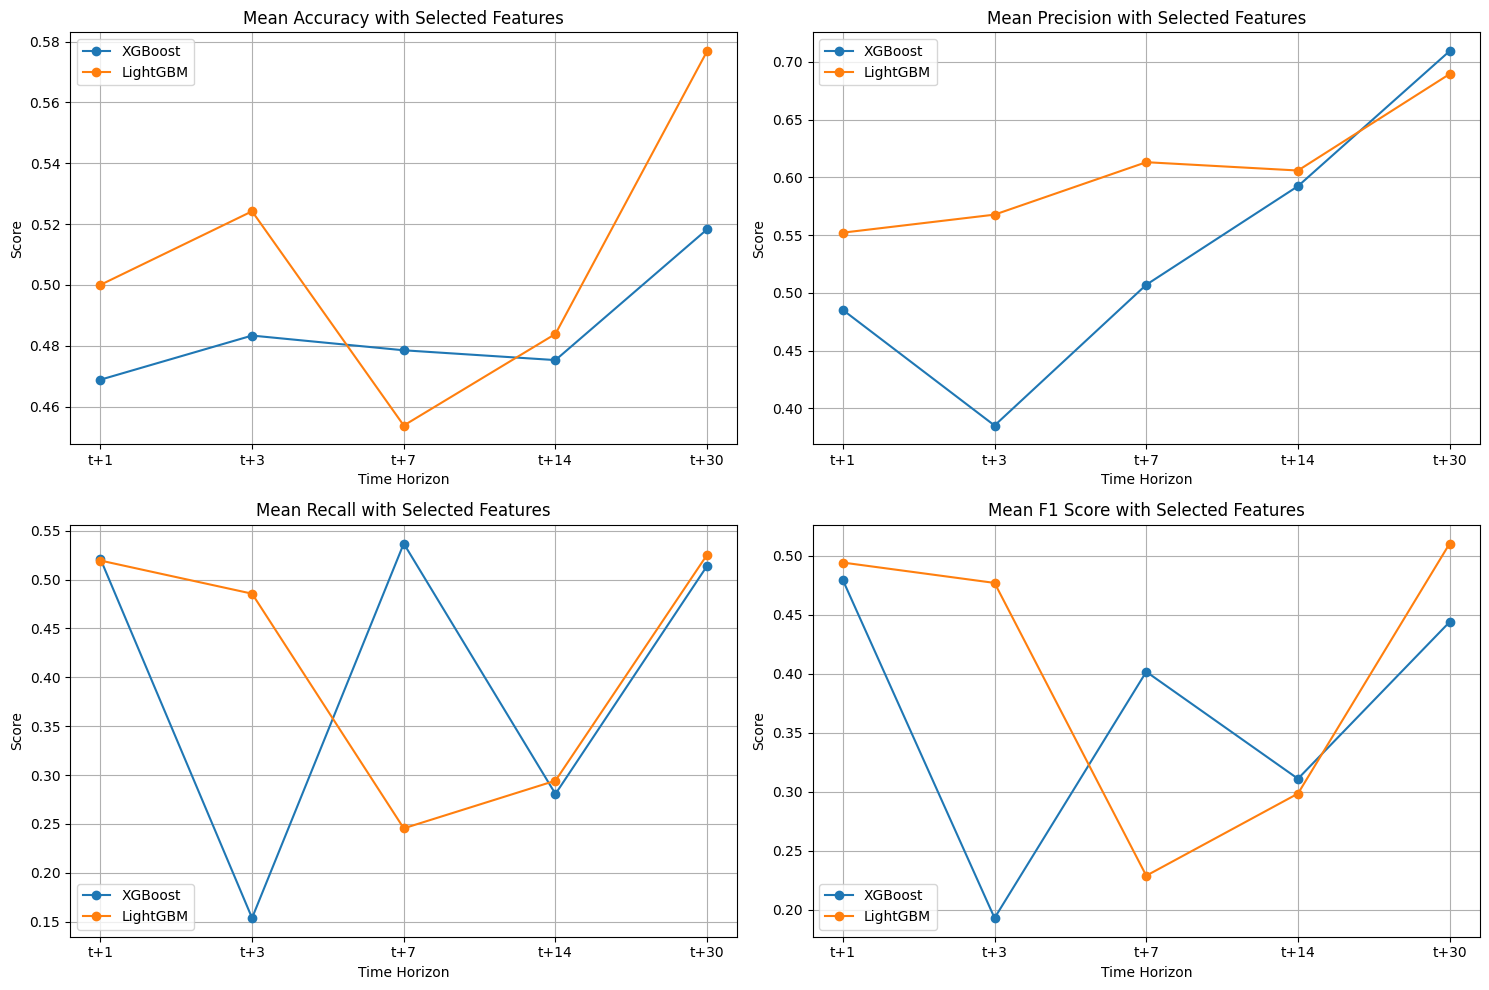


Selected features for XGBoost_1:
Number of features: 2
Features: ['DiffMean', 'IssContNtv']

Selected features for XGBoost_3:
Number of features: 5
Features: ['SER', 'PriceUSD', 'CapMrktCurUSD', 'VelCur1yr', 'SplyAdrBalUSD1M']

Selected features for XGBoost_7:
Number of features: 8
Features: ['DiffLast', 'VelCur1yr', 'SplyAdrBal1in100K', 'AdrBalUSD1MCnt', 'AdrBalNtv0.1Cnt', 'AdrBalNtv0.001Cnt', 'SplyAct2yr', 'SplyAdrBalNtv1']

Selected features for XGBoost_14:
Number of features: 15
Features: ['VelCur1yr', 'AdrBalNtv0.01Cnt', 'ReferenceRateETH', 'AdrBalUSD10KCnt', 'CapRealUSD', 'ROI1yr', 'SplyAdrBalUSD100K', 'AdrBal1in100MCnt', 'AdrBalUSD10MCnt', 'VtyDayRet180d', 'SplyActPct1yr', 'AssetCompletionTime', 'AdrBalCnt', 'SplyAct10yr', 'AdrBalUSD1KCnt']

Selected features for XGBoost_30:
Number of features: 16
Features: ['VelCur1yr', 'AdrBalUSD10MCnt', 'CapAct1yrUSD', 'AdrBalNtv0.01Cnt', 'SplyAct10yr', 'SplyAdrBalUSD100K', 'CapRealUSD', 'NVTAdj90', 'SplyAdrBalUSD10K', 'SplyMiner1HopAllNtv',

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Define thresholds for each model
importance_thresholds = {
    "XGBoost": 0.015,
    "LightGBM": 40  # Adjust as needed per model
}

def get_feature_importance(model, X, y, feature_names):
    """Calculate feature importance scores."""
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        importance = np.zeros(X.shape[1])
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

def select_features(X, y, model, feature_names, model_name):
    """Select features based on a model-specific importance threshold."""
    importance_threshold = importance_thresholds.get(model_name)  # Use default if not specified
    importance_df = get_feature_importance(model, X, y, feature_names)
    selected_features = importance_df[importance_df['importance'] > importance_threshold]['feature'].tolist()
    return selected_features, importance_df

def plot_feature_importance(importance_df, title):
    """Plot feature importance."""
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title(f'Top 20 Feature Importance - {title}')
    plt.tight_layout()
    plt.show()

# Initialize models
models = {
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}
# Determine o maior horizonte
max_horizonte = max(horizontes)

# Remova as últimas linhas do dataframe para garantir o mesmo período
btc_df_common = btc.iloc[:-max_horizonte]

btc_df_common = btc[(btc.index >= '2017-11-21') & (btc.index <= '2024-01-04')]

# Inicialize uma estrutura para armazenar outputs e probabilidades
output_storage = {model_name: {} for model_name in models.keys()}
# Feature selection and evaluation
all_results = []
selected_features_dict = {}

for model_name, model in models.items():
    print(f"\nPerforming feature selection for {model_name}:")

    for horizonte in horizontes:
        target_col = f'Direction_t+{horizonte}'
        btc_df_h = btc_df_common .dropna(subset=[target_col])

        # Prepare initial features and target
        X = btc_df_h.iloc[:, :-13]
        y = btc_df_h[target_col]
        feature_names = X.columns.tolist()

        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Select features using model-specific importance threshold
        selected_features, importance_df = select_features(
            X_scaled, y, model, feature_names, model_name
        )

        # Plot feature importance
        plot_feature_importance(importance_df, f"{model_name} - Horizon {horizonte}")

        # Store selected features
        selected_features_dict[f"{model_name}_{horizonte}"] = selected_features
        print(f"Selected {len(selected_features)} features for horizon {horizonte}")

        # Use selected features for training and evaluation
        X_selected = X[selected_features]

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': []
        }

        y_preds = []
        y_probas = []

        # Cross-validation with selected features
        for train_index, test_index in tscv.split(X_selected):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Scale features
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Train and evaluate
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            y_preds.extend(y_pred)

            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_scaled)
                y_probas.extend(y_proba[:, 1])

            # Calculate metrics
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['Recall'].append(recall_score(y_test, y_pred))
            metrics['F1 Score'].append(f1_score(y_test, y_pred))

        output_storage[model_name][f't+{horizonte}'] = {
            'predictions': np.array(y_preds),
            'probabilities': np.array(y_probas)
        }

        # Store results
        all_results.append({
            'Model': model_name,
            'Horizonte': f't+{horizonte}',
            'N_Features': len(selected_features),
            'Mean Accuracy': np.mean(metrics['Accuracy']),
            'Mean Precision': np.mean(metrics['Precision']),
            'Mean Recall': np.mean(metrics['Recall']),
            'Mean F1 Score': np.mean(metrics['F1 Score'])
        })

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name} at t+{horizonte}\n(Selected Features)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Display results
results_df = pd.DataFrame(all_results)
print("\nResults with Selected Features:")
print(results_df)

# Compare feature selection impact
plt.figure(figsize=(15, 10))
metrics_to_plot = ['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score']

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    for model in models.keys():
        model_data = results_df[results_df['Model'] == model]
        plt.plot(model_data['Horizonte'], model_data[metric], marker='o', label=model)
    plt.title(f'{metric} with Selected Features')
    plt.xlabel('Time Horizon')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print selected features for each model and horizon
for key, features in selected_features_dict.items():
    print(f"\nSelected features for {key}:")
    print(f"Number of features: {len(features)}")
    print("Features:", features)

for model_name, horizons in output_storage.items():
    for horizon, data in horizons.items():
        np.save(f"{model_name}_{horizon}_predictions.npy", data['predictions'])
        np.save(f"{model_name}_{horizon}_probabilities.npy", data['probabilities'])

# Save the outputs for later use in the meta-model
with open('model_outputs_block.pkl', 'wb') as f:
    pickle.dump(output_storage, f)

print("Model outputs saved successfully!")


In [18]:
# prompt: Filter btc_df_common to be between 2017-11-21 and 2024-01-04

# Assuming 'btc' DataFrame is already defined and populated as in the provided code.
# Filter btc_df_common to the specified date range
btc_df_common

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,Direction,Direction_t+1,Direction_t+3,Close_t+3,Direction_t+7,Close_t+7,Direction_t+14,Close_t+14,Direction_t+30,Close_t+30
time,,,,,,,,,,,,,,,,,,,,,
2017-11-21,981593.0,9534.0,1673026.0,8603089.0,889.0,444362.0,4217277.0,61.0,111198.0,22533561.0,...,1,1,1,8232.422333,1,9932.194180,1,11736.754067,1,15633.833650
2017-11-22,869698.0,9521.0,1680900.0,8643423.0,889.0,446289.0,4241246.0,61.0,111384.0,22600641.0,...,0,0,1,8760.165442,1,9800.027552,1,13992.132337,1,14305.718344
2017-11-23,959240.0,9511.0,1686720.0,8683044.0,903.0,447506.0,4256252.0,61.0,111285.0,22682081.0,...,1,1,1,9319.903315,1,9996.714972,1,17032.293376,1,14910.858105
2017-11-24,905792.0,9518.0,1688452.0,8715292.0,907.0,447393.0,4268295.0,61.0,111369.0,22739971.0,...,1,1,1,9730.728579,1,10808.958333,1,16298.487339,1,14026.346866
2017-11-25,922777.0,9483.0,1689201.0,8719533.0,904.0,446735.0,4275156.0,61.0,111380.0,22772691.0,...,1,1,1,9932.194180,1,10934.859986,1,15050.021954,1,14080.942260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,791644.0,8996.0,3073881.0,20923258.0,963.0,554275.0,9617658.0,41.0,100923.0,52327173.0,...,1,1,1,42773.651542,1,43844.195950,0,41888.151307,1,42950.054128
2024-01-01,827239.0,9000.0,3074529.0,20917258.0,962.0,554531.0,9615809.0,41.0,100944.0,52323401.0,...,1,1,1,44250.745267,1,46981.324300,0,42528.919249,0,42589.470806
2024-01-02,867688.0,8996.0,3073433.0,20872803.0,957.0,554187.0,9608470.0,41.0,100910.0,52223146.0,...,0,0,0,44146.322202,1,46084.005795,0,43171.447224,0,43020.359655


In [19]:
# Reset the index of missing_df to access column names
top_10_features = missing_df.reset_index().head(10)

# Create feature_importance_df with 'feature' and 'importance' columns
featdf = pd.DataFrame({
    'feature': top_10_features['index'],          # Get the feature names (column names)
    'importance': top_10_features['pct_missing']  # Get the percentage of missing values
})

# Ensure 'importance' column is of type float32
featdf['importance'] = feature_importance_df['importance'].astype('float32')

# Display the final DataFrame
featdf


NameError: name 'feature_importance_df' is not defined